In [1]:
import torch
import torchaudio
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import Audio

## 1. Creating the Dataset

In [2]:
from torchaudio.transforms import Resample

In [3]:
SAMPLE_FREQ = 16000
AUDIO_MAX_DURATION = 60

class LibriDataset(Dataset):

    def __init__(self, audioDir, newSampleFreq, maxLenght):
        self.audioList = self.getAudioList(audioDir)
        self.resampler = Resample(new_freq=newSampleFreq)
        self.maxLenght = maxLenght

    def getAudioList(self,audioDir):
        flac_files = []
        for root, dirs, files in os.walk(audioDir):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    flac_files.append(file_path)
        return flac_files


    def __len__(self):
        return len(self.audioList)

    def __getitem__(self, idx):
        waveform, sampleRate = torchaudio.load(self.audioList[idx])
        waveformResampled = self.resampler(waveform)
        waveformPadded = F.pad(waveformResampled, pad = (0,self.maxLenght - len(waveformResampled[0])))
        
        return waveformPadded

trainDataset = LibriDataset("data_cut", newSampleFreq = SAMPLE_FREQ, maxLenght = SAMPLE_FREQ * AUDIO_MAX_DURATION)

In [4]:
len(trainDataset),trainDataset[2][0].shape

(57, torch.Size([960000]))

In [5]:
BATCH_SIZE = 12

trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)

In [62]:
print(trainDataset[0][0].shape)
print(len(trainDataset))

Audio(trainDataset[40][0], rate = SAMPLE_FREQ)

torch.Size([960000])
57


### 2. HuBERT TEST

In [10]:
from transformers import HubertModel,AutoProcessor,AutoFeatureExtractor,Wav2Vec2Processor,HubertForCTC
import joblib
import torch.nn as nn

#### Importing the pretrained models for HuBERT and KMeans

In [53]:
#processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
#model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
#kmeans = joblib.load("./hubertKM/hubert_base_ls960_L9_km500.bin")


class SemanticTokenizer(nn.Module):
    
    def __init__(self, w2vCheckpointPath, kmeansCheckpointPath, chosenOutputLevel = 9):

        super().__init__()
        
        self.embedder = HubertModel.from_pretrained(w2vCheckpointPath)
        self.kMeans = joblib.load(kmeansCheckpointPath)
        self.chosenOutputLevel = chosenOutputLevel

        self.kMeans.cluster_centers_ = self.kMeans.cluster_centers_.astype(float)
        
    def forward(self, x):
        embeddings = self.embedder(x, output_hidden_states = True).hidden_states[self.chosenOutputLevel].squeeze()
        
        # Normalize embeddings (not possible with pretrained models)
        
        #mean = embeddings.mean(dim=1, keepdim=True)
        #std = embeddings.std(dim=1, keepdim=True)
        #normalizedEmbeddings = (embeddings - mean) / std
        
        normalizedEmbeddings = embeddings

        # Predict semantic tokens
        semanticTokens = self.kMeans.predict(normalizedEmbeddings)

        return semanticTokens, normalizedEmbeddings

# A semantic tokenizer
# Input: (w2vCheckpointPath, kmeansCheckpointPath)
# Output: (semanticTokens, normalizedEmbeddings)
w2vBERT = SemanticTokenizer("facebook/hubert-base-ls960","./hubertKM/hubert_base_ls960_L9_km500.bin")  


#### Computing semantic tokens

In [54]:
#inputValues = processor(trainDataset[0][0], sampling_rate =SAMPLE_FREQ, return_tensors="pt").input_values

with torch.no_grad():
    #out = model(trainDataset[0], output_hidden_states = True)
    #out = model(next(iter(dataLoader)).squeeze(), output_hidden_states = True)
    semanticTokens, embeddings = w2vBERT(trainDataset[0])


In [57]:
semanticTokens

array([ 17,  17, 289, ..., 193, 193,  17])

#### Visualizing embeddings

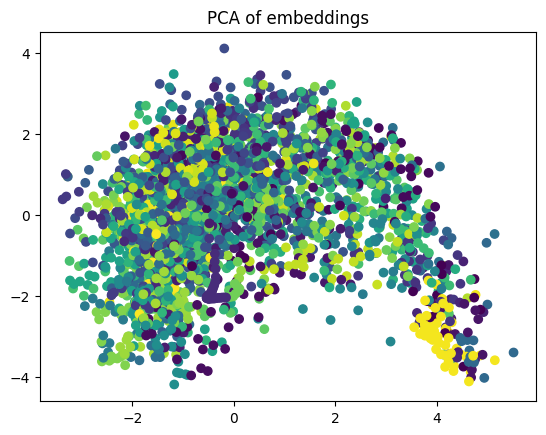

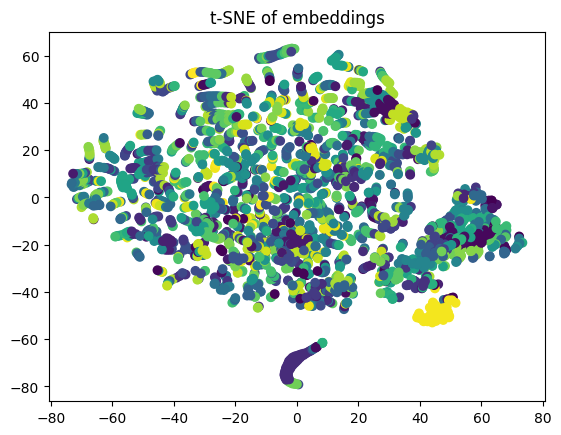

In [58]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=semanticTokens)
plt.title('PCA of embeddings')
plt.show()

# t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(embeddings)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=semanticTokens)
plt.title('t-SNE of embeddings')
plt.show()

#### Check with another implementation (OPTIONAL)

In [ ]:
# Models from https://github.com/lucidrains/audiolm-pytorch

!pip install audiolm-pytorch

In [61]:
from audiolm_pytorch import HubertWithKmeans

wav2vec = HubertWithKmeans(
    checkpoint_path = './hubertKM/hubert_base_ls960.pt',
    kmeans_path = './hubertKM/hubert_base_ls960_L9_km500.bin'
)

with torch.no_grad():
    semanticTokensAlt = wav2vec(trainDataset[0])
    
# Test if tokens are equal
tokensEqualityTest = not (semanticTokensAlt.squeeze() - semanticTokens).any()
tokensEqualityTest

True